[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mortfer/keras-gsam/blob/master/examples/gsam_comparison.ipynb)

## Initial Setup

In [4]:
%pip install git+https://github.com/mortfer/keras-gsam.git
import tensorflow as tf
from tensorflow.keras.models.experimental import SharpnessAwareMinimization
import copy
import matplotlib.pyplot as plt
import time
from gsam import GSAM
from gsam.resnet_cifar10 import get_resnet

print(tf.__version__)
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

  Cloning https://github.com/mortfer/keras-gsam.git to /tmp/pip-req-build-5idkwe3h
  Running command git clone --filter=blob:none --quiet https://github.com/mortfer/keras-gsam.git /tmp/pip-req-build-5idkwe3h
  Resolved https://github.com/mortfer/keras-gsam.git to commit b2b5a03e9e15a63366892e1ed7cacba145007261
  Preparing metadata (setup.py) ... done
2.12.0


Number of accelerators:  8


In [5]:
def plot_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

## Load Dataset and Prepare Data Loaders

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

170498071/170498071 [==============================] - 8s 0us/step
Training samples: 50000
Testing samples: 10000


In [7]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
print(f"Batch size: {BATCH_SIZE}")
AUTO = tf.data.AUTOTUNE

def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(scale, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Batch size: 1024


## Define Callbacks

In [8]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

## Train a Regular ResNet20 Model

In [ ]:
with strategy.scope():
    model = get_resnet(n=2) #resnet20

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=200) # 200 eppochs since SAM takes two backprop steps for an update
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/200
49/49 [==============================] - 42s 405ms/step - loss: 1.9098 - accuracy: 0.2914 - val_loss: 3.4451 - val_accuracy: 0.1099 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 3s 65ms/step - loss: 1.5928 - accuracy: 0.4140 - val_loss: 7.3959 - val_accuracy: 0.1136 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 3s 63ms/step - loss: 1.4361 - accuracy: 0.4780 - val_loss: 4.1616 - val_accuracy: 0.1571 - lr: 0.0010
Epoch 4/200
49/49 [==============================] - ETA: 0s - loss: 1.3182 - accuracy: 0.5262
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 3s 64ms/step - loss: 1.3182 - accuracy: 0.5262 - val_loss: 3.4476 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 4s 87ms/step - loss: 1.2282 - accuracy: 0.5616 - val_loss: 2.1262 - val_accuracy: 0.2921 - lr: 5.0000e-04
Epoch 6/200
49/49 [==============================] - 4s 80ms

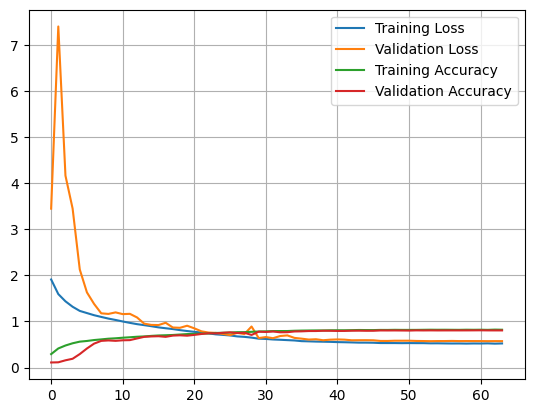

In [ ]:
utils.plot_history(history)

## Train a SAM Resnet20 Model


In [ ]:
with strategy.scope():
    sam_model = SharpnessAwareMinimization(get_resnet(n=2))#resnet20
sam_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {sam_model.model.count_params()/1e6} M")

Total learnable parameters: 0.575114 M


In [ ]:
start = time.time()
sam_history = sam_model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
49/49 [==============================] - 49s 465ms/step - loss: 2.9259 - accuracy: 0.0898 - val_loss: 2.2059 - val_accuracy: 0.2077 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 6s 121ms/step - loss: 2.1746 - accuracy: 0.1581 - val_loss: 1.9544 - val_accuracy: 0.2975 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 5s 102ms/step - loss: 2.0318 - accuracy: 0.2038 - val_loss: 1.8333 - val_accuracy: 0.3323 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 5s 94ms/step - loss: 1.9394 - accuracy: 0.2438 - val_loss: 1.7719 - val_accuracy: 0.3454 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 4s 91ms/step - loss: 1.8511 - accuracy: 0.2798 - val_loss: 1.6534 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 5s 100ms/step - loss: 1.7727 - accuracy: 0.3092 - val_loss: 1.5870 - val_accuracy: 0.4217 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 4s 92ms/step

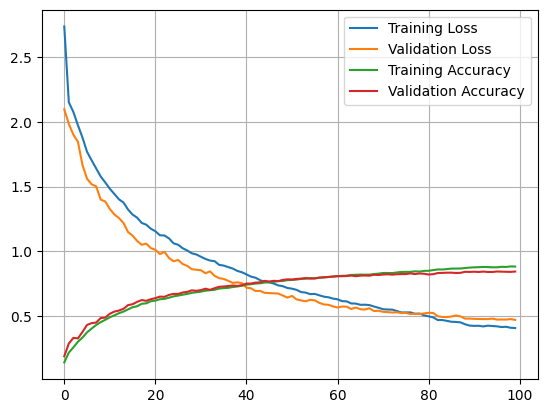

In [ ]:
plot_history(sam_history)

## Train a GSAM ResNet20 Model

In [ ]:
with strategy.scope():
  gsam_model = GSAM(get_resnet(n=2), alpha=0.005) #resnet20
gsam_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {gsam_model.model.count_params()/1e6} M")

start = time.time()
gsam_history = gsam_model.fit(train_ds,
                  validation_data=test_ds,
                  callbacks=train_callbacks,
                  epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Total learnable parameters: 0.575114 M
Epoch 1/100
49/49 [==============================] - 56s 480ms/step - loss: 2.6301 - accuracy: 0.1001 - val_loss: 2.1434 - val_accuracy: 0.2073 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 4s 84ms/step - loss: 2.1521 - accuracy: 0.1631 - val_loss: 2.0073 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 4s 84ms/step - loss: 2.0846 - accuracy: 0.1916 - val_loss: 1.9029 - val_accuracy: 0.3202 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 5s 92ms/step - loss: 1.9814 - accuracy: 0.2319 - val_loss: 1.7604 - val_accuracy: 0.3343 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 5s 93ms/step - loss: 1.8641 - accuracy: 0.2787 - val_loss: 1.6564 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 4s 85ms/step - loss: 1.7757 - accuracy: 0.3095 - val_loss: 1.5770 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 7/100
49/49 [==========

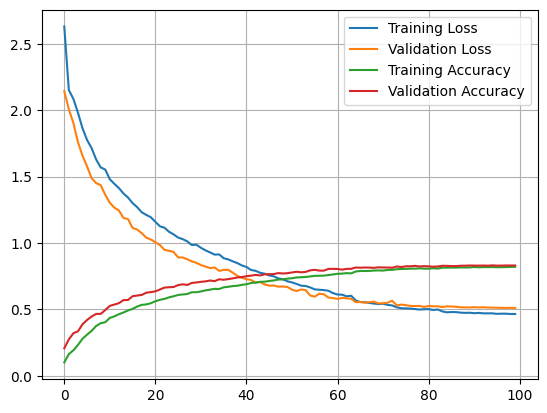

In [ ]:
plot_history(gsam_history)